# Backpropagation in depth

In the [last lesson](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/rnn.ipynb), we learned how to create a recurrent neural network.  We now know how to build several network architectures using components like dense layers, softmax, and recurrent layers.

We've been a bit loose with how we cover backpropagation, so that neural network architecture is easier to understand.  Backpropagation is how a neural network calculates how much to change each parameter in the network (the gradient).  In this lesson, we'll do a deep dive into how backpropagation works.  We'll do this by building a computational graph to keep track of which changes we make to input data.

A computational graph looks like this:

![](comp_graph.png)

It shows all the individual operations we performed (like multiplication) to modify the value of `X`, in order.  Keeping track of a computational graph is how we know how to reverse our operations to do backpropagation.

# The Softmax function

We'll first build a computational graph of the softmax function, then backpropagate through that graph to get the gradient against our inputs.  We introduced the softmax function in a previous lesson.  It's used to convert the output of a neural network into probabilities that can be used as predictions.  The softmax function is defined as:

$$\zeta=\frac{e^{\hat{y_{i}}}}{\sum_{j=0}e^{\hat{y_{j}}}}$$

For each row of our neural network output, we raise $e$ to the power of our output value, then divide by the sum of $e$ raised to the power of each of the outputs for that row.

The softmax function looks like this in code:

In [2]:
import numpy as np

def softmax_func(normalized):
    raised = np.exp(normalized)
    output = raised / np.sum(raised, axis=1).reshape(-1,1)
    return output

We can test the softmax function using some fake data that we generate:

In [3]:
# 5 rows and 3 columns of random numbers
x = np.random.rand(5, 3)

# Generate random correct labels for later
# Exactly one label per row will be correct
y = np.zeros_like(x)
inds = (np.arange(0,y.shape[0]), np.random.randint(0, 3, size=y.shape[0]))
y[inds] = 1

`x` is our input to the softmax function.  It has `3` columns.  `y` is our target, where each row is a one-hot encoded vector.  The `1` will correspond to the correct label for each row.

We can then apply the softmax function:

In [4]:
normalized = x - np.max(x, axis=-1).reshape(-1,1)
softmax_func(normalized)

array([[0.36880196, 0.33076319, 0.30043485],
       [0.35141995, 0.21574601, 0.43283403],
       [0.42527348, 0.29515779, 0.27956873],
       [0.25037301, 0.3852874 , 0.36433959],
       [0.25885158, 0.36256327, 0.37858516]])

In the above code, we subtract the maximum from each element in the row before passing the data into the softmax function.  This prevents numerical underflow or overflow.  Each [numeric type](https://numpy.org/doc/stable/user/basics.types.html) (float, integer, etc) can only hold a certain number of digits.  For example, floating point 16 can store 5 exponent bits, and ten digit bits (each bit is only base 2, so this is less than the same number of base-10 digits).  The maximum value we can store in `float16` is `65500`:

In [5]:
# Check the maximum value we can assign to float16
np.finfo('float16').max

65500.0

In [6]:
# This is an example of numeric overflow, where we store more digits than float16 can hold
a = np.array([0], dtype=np.float16)
a[0] = 6.55e5

/var/folders/xz/9z84c__j28g8tg28bmcthjj00000gn/T/ipykernel_32179/2542651828.py:3: RuntimeWarning: overflow encountered in cast
  a[0] = 6.55e5


When we raise $e$ to a very large or small number, we can generate a number that is too large to store in our specific data type.  Subtracting the max gives us the same end result, but reduces the risk of overflow.  Feel free to try the softmax out with and without subtracting the max to see how it works!

# Staged Softmax

Instead of computing the softmax derivative, we previously used the fact that the derivative of the softmax and negative log likelihood functions "cancel out", and end up with a derivative of $p-y$.  But what if we want to find the derivative ourselves?

We can approach it analytically, and find the derivative of the entire function.  We can even use SymPy to help us do the derivation, like we did in an earlier lesson.  Another method is to break the softmax function apart into individual operations.  Each operation will make a single modification to the data:

![](images/comp_graph/softmax_steps.svg)

We perform 3 operations on the data:

- Exp - we raise e to the power x.
- Sum - we add up the $e^x$ values for each row.
- Divide - we divide the $e^x$ values by the sums.

Note that the output of `Exp` is passed to both the `Sum` and `Divide` operations.

By breaking up the softmax this way, we can take the derivative of each individual piece instead of the whole function at once.  By the [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review), multiplying the derivative of each individual operation will result in the derivative of the whole function.  We used the chain rule in previous lessons to find the partial derivative of the loss with respect to the model weights and biases.

Now we can build the forward pass of our staged softmax.  The derivative of multiplication is easier to calculate than division, so we'll swap some of our operations to remove the division.

Luckily for us, raising a value `x` to the power `-1` is the same as taking `1/x`.  So instead of dividing `Exp/Sum`, we can do `Exp * Sum ^ -1$, leaving us with these operations:

- Exp
- Sum
- Pow - we invert the sum by raising to the power `-1`
- Multiply - we multiply the inverted sum and the exp values

In [7]:
raised = np.exp(x) # step 1
summed = np.sum(raised, axis=-1).reshape(-1,1) # step 2.  reshape so each row has 1 column.
pow = summed ** -1 # step 3
staged_softmax = raised * pow # step 4

In [8]:
staged_softmax

array([[0.36880196, 0.33076319, 0.30043485],
       [0.35141995, 0.21574601, 0.43283403],
       [0.42527348, 0.29515779, 0.27956873],
       [0.25037301, 0.3852874 , 0.36433959],
       [0.25885158, 0.36256327, 0.37858516]])

Our staged softmax has the exact same output as our original function.

# Softmax Derivative

To get the derivative of the softmax, we need to reverse the operations we did before:

![](images/comp_graph/softmax_steps_full_bwd.svg)

To compute the full derivative, here are the steps we need to follow:

1. Start at the final step.  Take in the loss gradient as the input, and multiply by the derivative of the final step.
2. Pass the gradient to the previous operation.
2. Continue calculating the derivative of each operation, and multiplying by the gradient.  Note that `Exp` is input to two operations, so it will sum both gradients.
4. Continue until we reach the first operation.

To calculate loss, we'll use negative log likelihood, which is $NLL = - \sum_{i=0} y_{i} \log p_{i}$.  Since $y$ is only non-zero at one position per row, this will only have a single term (basically $-y_{i} * \log p_{i}$ where $i$ is the correct label where $y$ equals `1`).

We'll use the negative log likelihood derivative below:

In [9]:
def nll_grad(y, pred):
    return -1 * y / pred

loss_grad = nll_grad(y, staged_softmax)

We can then calculate the softmax derivative by multiplying the derivatives of the individual operations.  Remember that a derivative is the rate of change of a function as we change the input.

- Exp - the derivative of $e^x$ is $e^x$ (this is a very cool property of $e$!)
- Sum - since a sum operation will combine input elements into one, we just distribute the gradient over all input elements.  A change to any of the input elements will have a direct impact on the output.
- Pow - the derivative of $x^{-1}$ is $-1 * x^{-2}$.  More on this [here](https://www.khanacademy.org/math/old-ap-calculus-ab/ab-derivative-rules/ab-diff-negative-fraction-powers/a/power-rule-review).
- Multiply - the derivatives of $x*y$ are $y$ wrt $x$ and $x$ wrt $y$.  This is because any change to $x$ is multiplied by $y$, and vice versa.  Thus the rate of change of $x$ is $y$, and vice versa.

We can now create the backward pass of our staged softmax.  The backward pass will start with the loss gradient.  This will be a matrix showing how much we need to adjust each of the output values from our softmax to reduce our loss.  We can then compute gradients for each operation, ending with the gradient against the input, `x`.  If `x` was the output of a neural network, we would continue backpropagation at that point to adjust the network parameters.

We'll name each gradient according to the step it is a gradient for, not the step it is coming from.  So `raised_grad` is the gradient on `raised`.

In [10]:
# Step 4 derivative
raised_grad = loss_grad * pow
pow_grad = loss_grad * raised
pow_grad = np.sum(pow_grad, axis=-1).reshape(-1,1) # reshape gradient to match input data

# Step 3
summed_grad = (-1 * summed ** -2) * pow_grad

# Step 2
raised_grad_2 = np.ones_like(raised) * summed_grad # distribute gradient across inputs

# Step 1
raised_grad += raised_grad_2 # sum incoming gradients
staged_softmax_grad = raised_grad * np.exp(x)

We did two things above that might be confusing.  The first is that we summed 2 gradients on raised.  This is because raised connects to 2 operations, and both have separate gradients.  Whenever this happens, we sum the gradients.

The second is that we reshaped `pow_grad` to have a single column.  This is to match `pow`, which only had `1` column in the forward pass.  Whenever a gradient doesn't match the shape of the input data, we change the size of the gradient to match it.  This is because the gradient represents the partial derivative against the input data to the operation.


We can compare our result to the derivative of the softmax equation to make sure everything worked.  The derivative of the softmax is $S_{i}((i==j) - S_{j})$.  We take each element of a single row in the output of a softmax, like this:

    [0.28, 0.25, 0.47]

We then compare each element against each other element.  So we could start at element `0` (`.28`), and compare it to itself.  Then `i` is `0` and `j` is `0`.  So the equation is `.28 * (1 - .28)`.  When we then keep `i` the same, but move `j` to `1`.  The equation becomes `.28 * (0 - .25)`.  And so on, until we construct a matrix like this:

![](images/comp_graph/softmax_deriv.svg)

We then sum across the rows and multiply by the incoming gradient to get the partial derivative against the inputs.  We can define the softmax derivative in code:

In [11]:
def softmax_grad_func(softmax, loss_grad):
    output = np.zeros_like(softmax)
    for i in range(softmax.shape[0]):
        sm_row = softmax[i,:]
        sm_grad = (-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))
        row_grad = sm_grad * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

We then compare our derivative by stages with the derivation.  The `np.allclose` function tells us if all the values in an array are close to another array.  We use this instead of `==` because there are small numerical differences in similar computations with numpy.

In [12]:
derived_softmax_grad = softmax_grad_func(staged_softmax, loss_grad)
np.allclose(derived_softmax_grad, staged_softmax_grad)

True

We can also compare the gradient we computed of the loss and softmax together with the derivative of both together, which is `p-y`:

In [13]:
np.allclose(staged_softmax_grad, staged_softmax - y)

True

# Operations

Breaking the softmax into stages helped us understand the basic units of a computational graph.  But what if we don't want to have to type out all the code for the forward and backward pass every time?  It would be nice if we could only define the forward pass, and automatically have the backward pass happen.

We can do this by individually defining each operation, then mixing and matching the operations to create a more complex equation.  By doing this, we can create a computational graph like this one:

![](comp_graph.png)

Each node in the graph will be a separate class that knows how to do a forward and backward pass.  So we can just execute the graph to run forward and backward passes.

We can start out by defining the operations.  I've written a class called `Node`, which we can subclass to define each operation.  You can look at the code for `Node` if you want.  It gives us some nice methods for running the operations in a graph in order, both forward and backward:

- `apply_fwd` - runs the forward pass up to the node it is called on.
- `apply_bwd` - runs the backward pass from the node it is called on backwards.
- `generate_graph` - helps us visualize the computational graph.
- `generate_derivative_chains` - shows us the equation for calculating the partial derivative at a node.

For each operation, we just implement the `forward` and `backward` methods, which take in input data, and pass them through the operation.  The `Node` class takes care of the rest.

We'll use the same formulas for each operation that we used in our staged softmax earlier:

In [14]:
import sys, os
sys.path.append(os.path.abspath("../nnets"))
from graph import Node, Parameter, display_chain

class Exp(Node):
    def forward(self, x):
        return np.exp(x) # raise e to the power x

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.exp(x) * grad # multiply the incoming gradient by the derivative

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0] # Pull the x value used in the forward pass
        return np.ones_like(x) * grad # distribute the gradient over the input data shape

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache # Pull the x and exponent values used in the forward pass
        return grad * exponent * x ** (exponent - 1), 1

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache # Pull the x and y values used in the forward pass
        return grad * y, grad * x

As you can see above, we've defined the 4 operations that we need for our softmax in code.

We can now define our whole softmax operation as a computational graph.  When we initialize a `Node`, we pass in the nodes that feed into it.  If we're using the node to feed in data (like inputs), we use a special `Parameter` node:

In [37]:
# The input data for our network.  We set needs_grad=True so the gradient is calculated for this parameter in the backward pass.
# Desc is a short description of what the data in this node is.
X = Parameter(x, desc="X", needs_grad=True)

# Raise e to the power x.  Out is a description of the output of the node.
raised = Exp(X, out="e^X")
# Sum the raised values.
summed = Sum(raised, out="sum(e^X)")

# Define -1 as a parameter, so we can use it as an exponent.
negative_one = Parameter(-1, desc="-1", needs_grad=False)
# Invert our sums
inverted = Pow(summed, negative_one, out="1 / sum(e^X)")
# Multiply the inverted sums by e^X
softmax = Multiply(raised, inverted, out="softmax(X)")

We can now use the `generate_graph` method on the `softmax` node to visualize the computational graph.

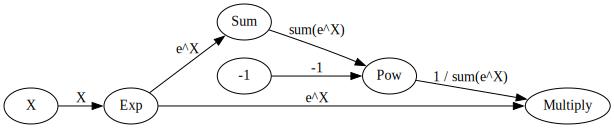

In [38]:
softmax.generate_graph()

In [17]:
operations_softmax = softmax.apply_fwd()

np.allclose(staged_softmax, operations_softmax)

True

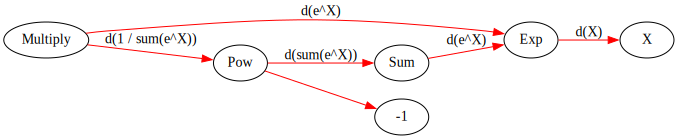

In [18]:
softmax.generate_graph(backward=True)

In [19]:
softmax.zero_grad()
softmax.apply_bwd(loss_grad)
operations_softmax_grad = X.grad

np.allclose(staged_softmax_grad, operations_softmax_grad)

True

In [20]:
softmax.generate_derivative_chains()
display_chain(X.display_partial_derivative())

<IPython.core.display.Latex object>

In [21]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w

    def backward(self, grad):
        x, w = self.cache
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        return grad, grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        new_grad[x < 0] = 0
        return new_grad

class Subtract(Node):
    def forward(self, x, y):
        return x - y

    def backward(self, grad):
        return grad, -grad

In [22]:
class Softmax(Node):
    def forward(self, x):
        return softmax_func(x)

    def backward(self, grad):
        x = self.cache[0]
        softmax = self.forward(x)
        return softmax_grad_func(softmax, grad)

class Dense(Node):
    def forward(self, x, w, b):
        return x @ w + b

    def backward(self, grad):
        x, w, b = self.cache
        return grad @ w, x.T @ grad, grad

In [23]:
sys.path.append(os.path.abspath("../data"))
from csv_data import SkyServerDatasetWrapper

# Load the data with 3 target values instead of the binary value from earlier
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [24]:
def encode(target, max_value=3):
    encoded = np.zeros((target.shape[0], max_value))
    inds = (np.arange(0,target.shape[0]), target.reshape(-1))
    encoded[inds] = 1
    return encoded

train_y = encode(train_y)

In [25]:
train_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

Random weight init

In [26]:
np.random.seed(0)
w1 = np.random.rand(13, 10)
b1 = np.random.rand(1, 10)
w2 = np.random.rand(10, 3)
b2 = np.random.rand(1, 3)

In [27]:
X = Parameter(train_x, desc="X", needs_grad=False)
Y = Parameter(train_y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

softmax = Softmax(add2, out="softmax(Z2)")

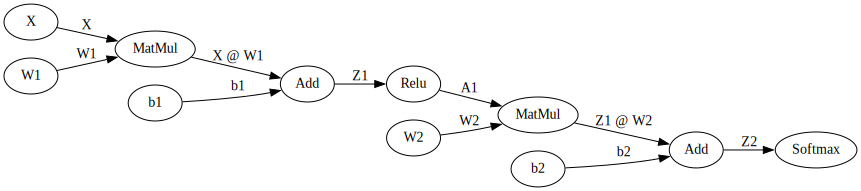

In [28]:
softmax.generate_graph()

In [29]:
predictions = softmax.apply_fwd()

predictions

array([[5.14085793e-01, 2.95571761e-01, 1.90342446e-01],
       [4.25086348e-01, 2.66558492e-01, 3.08355161e-01],
       [5.68681654e-01, 2.87285683e-01, 1.44032662e-01],
       ...,
       [9.39774768e-01, 5.76104164e-02, 2.61481553e-03],
       [9.12083861e-01, 8.18366292e-02, 6.07951003e-03],
       [8.64214297e-01, 1.34993035e-01, 7.92668045e-04]])

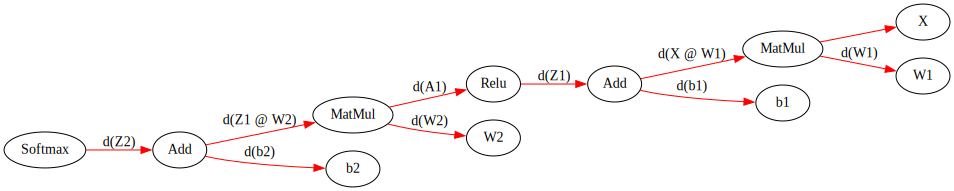

In [30]:
softmax.generate_graph(backward=True)

In [31]:
softmax.zero_grad()
loss_grad = nll_grad(train_y, predictions)
softmax.apply_bwd(loss_grad)
softmax.generate_derivative_chains()

In [32]:
w2_param.grad

array([[ 1078.86623385,  1452.92238635, -2531.7886202 ],
       [  685.34169939,  1438.06439063, -2123.40609002],
       [   11.39607931,  3488.94754329, -3500.3436226 ],
       [ 1990.1147882 ,   471.22083925, -2461.33562744],
       [ -538.48614737,  1989.95610171, -1451.46995434],
       [  823.86282115,  1728.75677685, -2552.619598  ],
       [  876.8179049 ,  2091.18377317, -2968.00167807],
       [ 1375.39946375,   693.7355912 , -2069.13505495],
       [  705.656685  ,  2007.41199158, -2713.06867658],
       [ 1247.97160254,  1539.37464607, -2787.34624861]])

In [33]:
display_chain(w2_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [34]:
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [35]:
l1 = train_x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2
probs = softmax_func(l2)

loss_grad = nll_grad(train_y, probs)

sm_grad = softmax_grad_func(probs, loss_grad)
l2_w_grad = l1_activated.T @ sm_grad
l2_b_grad = sm_grad.sum(axis=0)

l1_grad = sm_grad @ w2.T
l1_grad[l1 < 0] = 0

l1_w_grad = train_x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

In [36]:
np.allclose(l1_w_grad, w1_param.grad)

True